# Multi-agent System for Historic Vessel Maintenance

## Introduction

In this practice project, I simulate a real-life scenario where I am tasked with the development of an LLM Multi-agent System for automation of the process to determine whether and when the SS Great Britain requires maintenance.

The SS Great Britain, launched in 1843, is a revolutionary iron steamship designed by Isambard Kingdom Brunel. Now preserved as a museum ship in Bristol's Great Western Dockyard, this historic vessel requires continuous monitoring and maintenance to preserve its structural integrity and historical authenticity.

Credits: This project was inspired by an original problem designed by dr Marco Perez Hernandez. <br>
Data: Mock data for SS Great Britain inspection reports was generated with Claude Sonet 4.0 by Anthropic. All names of inspectors and any possible resemblance to actual persons is not intentional.


## Problem description

Although the ship is a complex structure with multiple interconnected systems, for this practice, I focus the system's analysis on three critical engineering perspectives across different sections of the vessel.
Marine heritage consultancies regularly inspect the condition of the ship and, at the end of their work, they submit inspection reports indicating their observations. The explored LLM MAS leverages the capabilities of LLMs to process these documents while organising and extracting the relevant information, aiding the end-user in their recommendation of a timeframe for the ship's maintenance.

### Ship Sections for Inspection

**Hull Sections:**

Forward Hull - Bow area including the figurehead and forward plating<br>
Midship Hull - Central section housing the engine room and main structural elements<br>
Aft Hull - Stern section including the propeller housing and rudder assembly<br>

**Superstructure Sections:**

Upper Deck - Main deck level including masts, rigging points, and deck structures<br>
Lower Deck - Passenger and cargo areas below the main deck<br>
Engine Room - Historic steam engine and related machinery spaces<br>

### Engineering Perspectives

**Structural Integrity:**
Focuses on the iron hull plating, rivets, frames, and load-bearing elements. This perspective examines:

* Hull plate corrosion and thickness measurements
* Rivet condition and structural joint integrity
* Frame deformation and stress analysis
* Watertight bulkhead condition

**Corrosion Management:**
Specialises in the preservation of iron and steel components against marine corrosion. This perspective covers:

* Surface rust classification and progression
* Protective coating effectiveness
* Galvanic corrosion at dissimilar metal joints
* Environmental exposure assessment

**Conservation Engineering:**
Addresses the unique requirements of preserving historic maritime artifacts while maintaining structural safety. This includes:

* Original material preservation vs. replacement decisions
* Historical authenticity of repair methods and materials
* Visitor safety integration with heritage preservation
* Climate control effectiveness in preservation areas

### Typical Inspection Schedule

| Company | Section Inspected | Perspective Focus | Date | Frequency |
|---------|------------------|-------------------|------|-----------|
| Marine Heritage Structural Ltd. | Forward Hull | Structural Integrity | 22-March-2025 | Quarterly |
| Corrosion Control Maritime Services | Midship Hull | Corrosion Management | 15-February-2025 | Bi-annually |
| Historic Preservation Engineering Ltd. | Upper Deck | Conservation Engineering | 08-January-2025 | Annually |
| Deep Hull Maritime Surveys | Aft Hull | Structural Integrity | 28-February-2025 | Quarterly |
| Engine Room Heritage Technical Services | Engine Room | Conservation Engineering | 12-March-2025 | Annually |


## Main objective

This system enables automated processing of complex inspection data while maintaining the specialised knowledge required for historic vessel preservation.

### Workflow Design



1) ``Document Extracting Agent``: extracts key insights from the reports
2) ``Evaluating Agent / Decission point``: the agent evaluates the insights extracted from the reports. If the insights meet requirements, the workflow continues, otherwise it goes back to the ``Document Extracting Agenteener``.
3) ``Orchestrator``: tasked with organising the insights, related to the condition of the ship by section and according to the three perspectives: 
    - *corrosion_management* 
    - *conservation_engineering* 
    - *structural_integrity*. 
4) ``Decission point``: assigning a specialist to each perspective of assessment
5) ``Assess Condition Agent``: takes the specific details for its perspective of interest and assesses the ship condition.
6) ``Synthesiser Agent``: uses the insight regarding corrosion management, conservation engineering and structural integrity to provide a maintenance timeframe.

## The System

### Tools

In [72]:
# Core langchain types of messages
from langchain_core.messages import HumanMessage, SystemMessage
# from langchain_core.tools import tool
from langchain_core.tools import StructuredTool

# For LangGraph workflow functionality
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Send

# Google Generative AI integration 
from langchain_google_genai import ChatGoogleGenerativeAI

# Other tools
import os, operator
from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display


### API Keys

In this project, I have used Google Gemini model. You can obtain your own key from [here](https://aistudio.google.com/app/apikey). This API_KEY is unique and you should use it for your development.

In [ ]:
API_KEY = "YOUR_KEY_HERE" # Substitute this with your own API key

os.environ['GOOGLE_API_KEY'] = API_KEY 

I choose **gemini-2.0-flash** LLM instance for the model's free tier, advanced capabilities over many tasks and special usefulness in agentic systems, as described [here.](https://ai.google.dev/gemini-api/docs/pricing)

In [74]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

### Loading the Reports 

In [75]:
# Set the path to the report files
data_path = "./data/"

# Reads all the .md files in data folder and stores them in a list of tuples with the name and the content of the file
def read_data():
    docs = []
    for file in os.listdir(data_path):
       
        if file.endswith('.md'):
            with open(os.path.join(data_path, file)) as f:
                docs.append((file, f.read()))
    return docs


docs = read_data()

### Data Structures

I define data structures for SS Great Britain inspection workflow that processes reports through specialised agents.
``ClassifiedCondition`` and ``ClassifiedConditionList`` store extracted insights classified by ship section and engineering perspective (*corrosion_management*, *conservation_engineering* and *structural_integrity*). Since I'm using parallel processing, I need both global and local states: ``ConditionState`` provides local state for individual specialist agents, while ``Condition`` stores their final assessments with expert ratings.
My main workflow state (``State``) tracks documents, tasks, and outputs from each agent. The condition attribute uses ``Annotated[list, operator.add]`` to merge results from parallel specialist agents automatically.

In [76]:
# Define types to classify insights extracted from the reports, according to the ship section and engineering perspective
class ClassifiedCondition(BaseModel):
    condition_details: str = Field(
        description="Condition Details of the ship classified by engineering perspective.",
    )
    perspective: str = Field(
        description="The specialist linked to the perspective of ship condition, just a single word e.g. corrosion, structural, conservation",
    )
    section: str = Field(
        description="The section or component the condition refers to, e.g. forward hull, aft hull, engine room, etc ",
    )

class ClassifiedConditionList(BaseModel):
    classified_condition_list: List[ClassifiedCondition] = Field(
        description="Condition Details of the ship classified by engineering perspective.",
    )

# Define local condition state (relevant for the engineering perspective)
class ConditionState(BaseModel):
    condition:str = Field(
        description="Summary condition of the ship by engineering perspective.",
    )
    perspective: str = Field(
        description="Engineering perspective.",
    )

# Define global condition state forthe entire workflow
class Condition(BaseModel):
    summary_condition:str = Field(
        description="Summary condition of the ship by engineering perspective.",
    )
    perspective: str = Field(
        description="Engineering perspective.",
    )
    rating_condition: str = Field(
        description="Rating of condition in scale 0 to 2.",
    )

# Define main data structure
class State(TypedDict):
    docs: str
    task: str
    insights: str
    assessment: str
    result: str
    classified_condition_list:ClassifiedConditionList
    condition:Annotated[list,operator.add]

### Extracting Agent

In [77]:
def doc_extracting_agent(state: State) :
    """Extract key insights from documents for the task """

    base_prompt = f"Concise but complete answer, no introduction. Extract key insights from: {state['docs']} to {state['task']}"
    
    if state.get("feedback"):
        msg = llm.invoke(
            f"{base_prompt} and taking into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(base_prompt)

    return { "insights": msg.content }

In [78]:
insight_requirements="concise, relevant, well supported and organised per perspective of condition of the ship, i.e. corrosion management, structural integrity and conservation engineering."

prompt_feedback = "Assessment that insights extracted for the task are "

class Feedback(BaseModel):
    result: Literal["Strong", "Weak"] = Field(
        description=f"{prompt_feedback} {insight_requirements}",
    )
    rationale: str = Field(
        description="The rationale for the assessment",
    )

evaluator = llm.with_structured_output(Feedback)

### Evaluating Agent

In [79]:
def evaluating_agent(state:State):
    """Evaluate the insights extracted from the documents for the task"""

    assessment = evaluator.invoke(f"Check the insights: {state['insights']} are {insight_requirements} for {state['task']} and concisely explain why")

    return { "result": assessment.result, "rationale": assessment.rationale }


### Orchestrator Agent

In [80]:
splitter =  llm.with_structured_output(ClassifiedConditionList)


def orchestrator(state: State):
    """Orchestrator that organises the insights related to the condition of the ship by perspective and section"""
    
    orchestrator_prompt = f"""Extract condition details per section of the ship from the insights {state['insights']} 
    and organise into unique engineering perspectives (corrosion management, structural integrity and conservation engineering). 
    Multiple condition details can be assigned to the same perspective. There is a specialist type of engineer related to each perspective."""
    
    result = splitter.invoke(orchestrator_prompt)

    return {"classified_condition_list":result.classified_condition_list} 

### Decision Point

Necessary to route the workflow depending on the LLM's output quality.

In [81]:
def route_task(state: State):
    """route the task to the appropriate function"""
    result = state.get("result")
    output = "Rejected + Feedback"
    if result == "Strong":
        output =  "Accepted"

    return output

### Assign Specialist

In [82]:
def assign_specialists(state: State):
    """Assign a specialist to each engineering perspective of assessment"""
    
    # Group classified_condition_list by perspective
    grouped_classified_condition_list = {}

    # Access each condition from the list of conditions
    for classified_condition in state["classified_condition_list"]:
        
        # Check if the perspective already doesn't exist in the dictionary
        if not classified_condition.perspective in grouped_classified_condition_list:    
            # Create the key with empty list for the perspective
            grouped_classified_condition_list[classified_condition.perspective] = []
            
        # Append the classified_condition under the given engineering perspective    
        grouped_classified_condition_list[classified_condition.perspective].append(classified_condition)
    
    return [Send("assess_condition", 
                 {"condition": grouped_classified_condition_list[s], "perspective":s}) for s in grouped_classified_condition_list.keys()]

### Assess Condition Agent

This agent takes the specific details for its perspective of interest and assesses the ship condition.

In [83]:
def assess_condition(state: ConditionState):
    """Assess the condition of the asset from each perspective"""

    condition_details = state["condition"]
    condition_details = "\n".join([f"- {cd}" for cd in condition_details])

    response = llm.with_structured_output(Condition).invoke(
        [
            SystemMessage(
                content=f"Assess the condition of the entire ship from condition_details: {condition_details}."
            ),
            HumanMessage(
                content=f" From the perspective of {state['perspective']}"
            ),
        ]
    )

    return {"condition": [response]}

### Synthesizer Agent

In [84]:
def synthesizer(state: State):
    """Synthesise condition of the ship. It calls the LLM to determine the maintenance timeframe given the state of the ship"""

    # List of condition of the ship by perspective
    condition = state["condition"]

    output = ""

    # Go through each condition
    for c in condition:
        
        # Take each perspective, add its summary and rating and store in output
        output += f"Engineering perspective: {c.perspective}, Condition: {c.summary_condition} Rating of condition: {c.rating_condition}\n"

    prompt = f"""Given insights regarding corrosion management, structural integrity and conservation engineering, determine maintenance timeframe given the state: {output}. 
    Consider exactly three perspectives: corrosion management, structural integrity, conservation engineering. When determining maintenance timeframe recommendations clearly 
    state if the ship requires immediate attention or if current schedule is enough and potential repairs can wait."""
    
    result = llm.invoke(prompt)
  
    return result

### Defining the Workflow Graph

In [85]:
mas_workflow = StateGraph(State)

## Add nodes

mas_workflow.add_node("doc_extracting_agent", doc_extracting_agent)
mas_workflow.add_node("evaluating_agent", evaluating_agent)
mas_workflow.add_node("orchestrator", orchestrator)
mas_workflow.add_node("assess_condition", assess_condition)
mas_workflow.add_node("synthesizer", synthesizer)

##  Add edges

mas_workflow.add_edge(START, "doc_extracting_agent")
mas_workflow.add_edge("doc_extracting_agent", "evaluating_agent")
mas_workflow.add_conditional_edges("evaluating_agent", 
                                   route_task,
                                   {
                                       "Accepted": "orchestrator", 
                                       "Rejected + Feedback": "doc_extracting_agent"
                                   }
                                  )
mas_workflow.add_conditional_edges(
    "orchestrator", assign_specialists, ["assess_condition"]
)
mas_workflow.add_edge("assess_condition", "synthesizer")
mas_workflow.add_edge("synthesizer", END)


# Compile the workflow
compiled_wf = None

compiled_wf = mas_workflow.compile()

Display the multi-agent workflow:

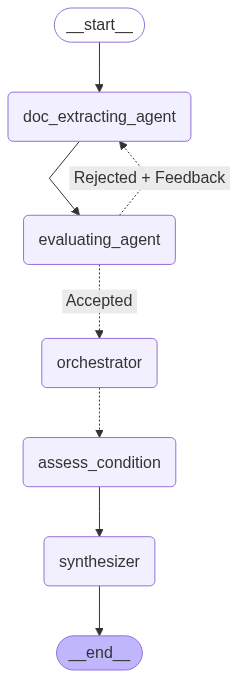

In [86]:
try:
    display(Image(compiled_wf.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Testing the MAS

In [87]:
# main task prompt
task_prompt = "Determine maintenance timeframe for SS Great Britain based on corrosion management, structural integrity and conservation engineering at March 2025"

response = compiled_wf.invoke({"docs": docs,"task": task_prompt})

In [88]:
# Present the MAS output
for condition in response["condition"]:
    print(f"Perspective: {condition.perspective}")
    print(f"Summary: {condition.summary_condition}")
    print("-" * 50)

Perspective: corrosion management
Summary: Address galvanic corrosion at the propeller shaft bearing, Spot-repair coating holidays on the midship hull
--------------------------------------------------
Perspective: structural integrity
Summary: The ship requires some structural work, continue monitoring hull plating and stern frame.
--------------------------------------------------
Perspective: conservation engineering
Summary: Schedule deep cleaning of less accessible engine room areas
--------------------------------------------------


## Summary

The multi-agent system successfully demonstrates its core functionality in processing domain-specific inspection reports and extracting structured insights for maintenance decision-making. The system effectively handles complex engineering terminology, quantitative measurements, and multi-perspective analysis across structural integrity, corrosion management, and conservation engineering domains.

**Key Achievements:**
- Automated extraction and categorisation of technical findings from unstructured inspection reports
- Successful integration of multiple engineering perspectives into coherent maintenance recommendations
- Effective handling of domain-specific terminology and measurement standards
- Demonstration of scalable architecture for processing multiple inspection sources

**Limitations and Future Work:**
The current evaluation relies primarily on LLM-generated mock data, which may not capture the full complexity and inconsistencies present in real-world inspection reports. Real inspection documents often contain:
- Inconsistent formatting and terminology across different inspection companies
- Incomplete or missing data sections

**Future Improvements:**
- Implementation of confidence scoring for extracted insights
- Development of robust error handling for incomplete or incosistent input data
- Validation with authentic inspection reports from maritime heritage organisations (if available)
- Extended testing across different vessel types and real inspection methodologies (if available)